### Урок 2. Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

#### 1. когда совершил первую покупку (сколько прошло с момента регистрации до момента покупки)

![ab_split](payments1.png "Payments2")

#### 2. по психотипам

![ab_split](psycho.png "Psycho")

#### 3. по платежам

![ab_split](payments.png "Payments")

#### 4. По эффективности взаимодействия (uplift)

![ab_split](uplift.png "Uplift")

#### 5. по интересам

![ab_split](interests.png "Interests")

И еще 100500 вариантов сегментирования, которое может быть полезно. 

Для чего полезно?

1. понимание аудитории, способность описать основные группы пользователей и их интересы
2. выявление сегментов с максимальной монетизацией
3. выбор маркетинговой стратегии
4. налаживание эффективного взаимодействия с пользователями

#### Пример из жизни (новостной портал)

Представим, что мы - компания-агрегатор новостей (новостной портал).

У нас есть:

1. читатели
2. новости

Для каждого пользователя мы можем за какой-то период (например, 1 день) достать из базы данных список прочитанных им новостей.

Для каждой новости мы можем вытащить текст и метаинформацию.

### Задача #1: нужно построить модель прогнозирования оттока - это наша downstream-задача. 

Нам нужны:

1. векторное представление пользователя
2. сегменты, описывающие интересы пользователя

p.s. в контексте нашей задачи - это одно и то же

### С чего начнем?

С векторного представления и сегментов новостей!

Есть два очевидных варианта как это сделать:

1. многоклассовая классификация
2. кластеризация документов с последующей попыткой их (кластера) интерпретировать

Проблема:

1. для классификации нам нужно сначала разметить новости - привлечение ручного труда

### Задача тематического моделирования

Терминология:

1. документ - коллекция слов 
2. тема - набор токенов (слов), совместно часто встречающихся в документах

Более формально:

1. тема - условное распределение на множестве терминов, p(w|t)
2. тематический профиль документа - условное распределение тем p(t|d)

Вопрос: что же нам дано (в терминах условной вероятности)?

Ответ: условное распределение слов в документах - p(w|d)

Прекрасное объяснение от Воронцова - http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

Тематическая модель позволяет нам получить p(w|t), p(t|d) по известным p(w|d)

![ab_split](tm1.png "TM1")

### Переходим к практике

In [1]:
import pandas as pd

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:72,5% !important; }</style>"))

pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

Наши новости

In [3]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,"Заместитель председателяnправительства РФnСергейnИвановnизбран председателем советаnПБК ЦСКАn. Как сообщаетnпресс-службаnармейцев, такое решение было единогласно принято на первом заседании совета клуба. Основной функцией этого органа будет обсуждение текущего состояния, планирование и утвержден..."
1,4896,"Матч 1/16 финала Кубка России по футболу был приостановлен судьей из-за взрыва пиротехнических снарядов, передает корреспондент «Газеты.Ru». Болельщики выбросили на поле петарды. Судья увел команды с поля в подтрибунное помещение. Динамовцы ушли, а торпедовцы остались у кромки поля. Сообщается, ..."
2,4897,"Форвард «Авангарда» Томаш Заборский прокомментировал игру своей команды в матче чемпионата КХЛ против «Атланта»n(4:3)n.nn«Мы провели плохой матч в Нижнем Новгороде против «Торпедо» и настраивались, что с первых же минут включимся в работу, — сказал Заборский. — У нас получилось забросить быстрый..."


In [4]:
news.tail(3)

,doc_id,title
26997,513443,"Американские ученые уточнили возраст расположенного в американском штате Аризона Гранд-Каньона, сообщается в их статье, опубликованной в научном журналеnNature Geosciencen.nТак, ученые полагают, что возраст каньона составляет примерно 5–6 млн лет, в то время как прежде было принято считать, что ..."
26998,513444,"За последние 50 лет тропический углеродный цикл стал в два раза чувствительнее к изменениям температуры, сообщается вnстатьеn, опубликованной в научном журнале Nature.nВ частности, американским ученым удалось выяснить, что повышение температуры в джунглях на 1° C приводит к тому, что в атмосферу..."
26999,513445,"У живших примерно 7 тыс. лет назад на территории современной Испании охотников-собирателей были голубые глаза и смуглая кожа, выяснили испанские ученые, статья которыхnопубликованаnв научном журнале Nature.nВосстановить облик La Braña, а именно так исследователи «окрестили» жившего в период мезо..."


Загрузим пользователей и списки последних прочитанных новостей

In [5]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [6]:
# !pip install gensim

In [7]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [8]:
# !pip install razdel
# !pip install pymorphy2

In [9]:
# предобработка текстов
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel

import pymorphy2

In [10]:
# nltk.download('stopwords')

stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [11]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [12]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|nn|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [13]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\Busi\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


Wall time: 23.2 s


In [14]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 43s


А теперь в 3 строчки обучим нашу модель

In [15]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [16]:
common_dictionary[10]

'взаимодействие'

Все просто - это словарь наших слов

Запускаем обучение

In [17]:
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [18]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [19]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(2, 0.14490137),
 (3, 0.057951253),
 (4, 0.07384094),
 (8, 0.07324749),
 (10, 0.03355841),
 (14, 0.5527861),
 (16, 0.047334775)]

In [20]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год это который рубль мочь рост также
topic_1: мальчик озеро соцсеть жир взорваться фото норвежский
topic_2: физика медицина кровь рекомендовать больной уточнять лёд
topic_3: женщина человек мужчина рейс задержать это исследование
topic_4: температура экипаж северный место вода высота южный
topic_5: год который свой это земля человек жизнь
topic_6: который военный год это власть санкция россия
topic_7: ребёнок цена тыс год млн гражданин семья
topic_8: погибнуть поверхность рак годовой фронт восточный отель
topic_9: это который сша человек россия мочь всё
topic_10: ракета египет дождь су экскурсия снежный воздух
topic_11: китай участок восток активность китайский доклад торговый
topic_12: ставка планета кольцо мэй билет сахар банк
topic_13: украина украинский гражданин киев народный сон украинец
topic_14: конкурс дыра обращение стать увидеть сайт знаменитый
topic_15: год который это исследование город находиться человек
topic_16: прогнозировать транспорт санктпетербург квартира

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [21]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [22]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.00000,0.00000,0.01297,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.07459,0.00000,0.00000,0.88266,0.00000,0.01102,0.00000,0.00000,0.00000,0.00000,0.01113
1,4896,0.00000,0.00000,0.31169,0.00000,0.00000,0.35124,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04290,0.27315,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,4897,0.00000,0.00000,0.14490,0.05785,0.07385,0.00000,0.00000,0.00000,0.07326,0.00000,0.03356,0.00000,0.00000,0.00000,0.55287,0.00000,0.04734,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,4898,0.25772,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.40318,0.00000,0.00000,0.00000,0.03034,0.00000,0.00000,0.10550,0.19355,0.00000,0.00000
4,4899,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.47748,0.00000,0.00000,0.00000,0.00000,0.04286,0.00000,0.00000,0.18722,0.00000,0.26898,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [23]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [24]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [25]:
doc_dict[293622]

array([0.13648446, 0.        , 0.        , 0.12210447, 0.        ,
       0.        , 0.14885312, 0.02298531, 0.        , 0.11994407,
       0.        , 0.        , 0.        , 0.        , 0.23329769,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.1238676 , 0.08198699, 0.        , 0.        ])

In [26]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     Среднее значение
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [27]:
get_user_embedding(user_articles_list)

array([0.15941853, 0.        , 0.00191423, 0.05107567, 0.00341535,
       0.07878571, 0.16406548, 0.01478833, 0.        , 0.06631303,
       0.        , 0.01318078, 0.        , 0.        , 0.00447703,
       0.09603349, 0.00501727, 0.01244238, 0.        , 0.        ,
       0.        , 0.31401623, 0.        , 0.        , 0.        ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [28]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [29]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал под

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [30]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.06426,0.00566,0.00000,0.09356,0.01014,0.03583,0.03740,0.09616,0.00232,0.07770,0.00000,0.01261,0.00000,0.04364,0.11127,0.18325,0.00825,0.03980,0.00000,0.00000,0.00000,0.13589,0.02120,0.00000,0.00000
1,u108690,0.07718,0.00242,0.00000,0.04823,0.00717,0.05731,0.09740,0.03292,0.00000,0.14668,0.00000,0.00485,0.00000,0.03321,0.00999,0.13249,0.00206,0.04782,0.01987,0.00331,0.00174,0.25278,0.00541,0.00000,0.00353
2,u108339,0.10283,0.00000,0.00272,0.02611,0.02830,0.04360,0.15155,0.01335,0.01353,0.07743,0.00000,0.00769,0.00000,0.00245,0.00908,0.32044,0.00000,0.03990,0.01204,0.00539,0.00000,0.11077,0.01373,0.00191,0.00000


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [31]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [32]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.06426,0.00566,0.00000,0.09356,0.01014,0.03583,0.03740,0.09616,0.00232,0.07770,0.00000,0.01261,0.00000,0.04364,0.11127,0.18325,0.00825,0.03980,0.00000,0.00000,0.00000,0.13589,0.02120,0.00000,0.00000,0
1,u108690,0.07718,0.00242,0.00000,0.04823,0.00717,0.05731,0.09740,0.03292,0.00000,0.14668,0.00000,0.00485,0.00000,0.03321,0.00999,0.13249,0.00206,0.04782,0.01987,0.00331,0.00174,0.25278,0.00541,0.00000,0.00353,1
2,u108339,0.10283,0.00000,0.00272,0.02611,0.02830,0.04360,0.15155,0.01335,0.01353,0.07743,0.00000,0.00769,0.00000,0.00245,0.00908,0.32044,0.00000,0.03990,0.01204,0.00539,0.00000,0.11077,0.01373,0.00191,0.00000,1


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [34]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [35]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22236558, 0.04999086, 0.34480705, 0.1508781 , 0.11939552,
       0.08281255, 0.06302002, 0.03404715, 0.11699578, 0.1943919 ])

In [37]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [38]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.237499, F-Score=0.623, Precision=0.532, Recall=0.751


In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1593  162]
 [  62  183]]


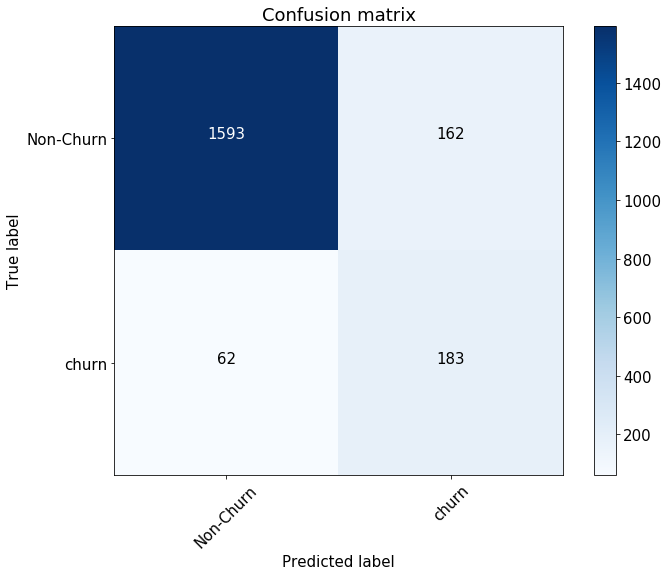

In [40]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [41]:
roc_auc_score(y_test, preds)

0.9317099831385546

In [42]:
mean_rating = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

### Медиана

In [43]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector


get_user_embedding(user_articles_list)

array([0.12004006, 0.        , 0.        , 0.        , 0.        ,
       0.01406113, 0.08438075, 0.        , 0.        , 0.01659563,
       0.        , 0.00663645, 0.        , 0.        , 0.        ,
       0.0977858 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.36029348, 0.        , 0.        , 0.        ])

In [44]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

#обучим наш пайплайн
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

In [45]:
median_rating = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

### Максимальное значение

In [46]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector


get_user_embedding(user_articles_list)

array([0.40033883, 0.        , 0.0114854 , 0.28377751, 0.02049213,
       0.34468317, 0.47768536, 0.06553932, 0.        , 0.22955711,
       0.        , 0.03737004, 0.        , 0.        , 0.0268622 ,
       0.21723954, 0.03010365, 0.05581421, 0.        , 0.        ,
       0.        , 0.58007115, 0.        , 0.        , 0.        ])

In [47]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

#обучим наш пайплайн
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

In [48]:
max_rating = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

### Минимальноеное значение

In [49]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.min(user_vector, 0)
    return user_vector


get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05065276, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [50]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

#обучим наш пайплайн
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

In [51]:
min_rating = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

In [52]:
results = pd.DataFrame({'mean': mean_rating, 'median': median_rating, 'max': max_rating, 'min': min_rating}).T
results.columns=['f1_score', 'precision', 'recall', 'roc_auc_score']
results

,f1_score,precision,recall,roc_auc_score
mean,0.62267,0.53179,0.75102,0.93171
median,0.72651,0.74359,0.71020,0.96139
max,0.75149,0.73256,0.77143,0.96811
min,0.52174,0.40449,0.73469,0.89284


### Вывод

Заполнение значениями медианы и максимума улучшили точность модели, а между precision и recall допустимый интервал. При использовании минимальных значений происходит обратное, наблюдается существенное снижение всех показателей.

### TF-IDF

In [3]:
users = pd.read_csv("users_articles.csv")

In [4]:
users.head()

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [28]:
users['articles'] = users['articles'].apply(lambda x: "".join([i.strip() for i in x.replace("[","").replace("]","")]), 
                                            1)

In [29]:
users['articles'].iloc[0]

'293672,293328,293001,293622,293126,1852'

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf.fit(users['articles'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [31]:
pd.DataFrame({'article_id': tfidf.get_feature_names(),
             'idf': tfidf.idf_})

,article_id,idf
0,10,8.88871
1,100,7.90788
2,1000,8.04141
3,1001,8.88871
4,1002,8.88871
...,...,...
14776,995,8.37788
14777,996,8.19556
14778,997,8.60103
14779,998,9.29417


In [32]:
pd.DataFrame({'article_id': tfidf.get_feature_names(),
             'idf': tfidf.idf_}).to_csv("articles_idf.csv", index=None)